In [ ]:
#requirements.txt
#pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
import random
from time import gmtime, strftime

from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import shap

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import TargetEncoder # bonus: sklearn-contrib
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
train = pd.read_csv('fraudTrain.csv')
test  = pd.read_csv('fraudTest.csv')

In [3]:
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
def calc_distance(lat1, long1, lat2, long2):
    """Определение дистанции между точками
    """
    R = 6373.0 # approximate radius of earth in km
    lat1 = radians(lat1)
    lon1 = radians(long1)
    lat2 = radians(lat2)
    lon2 = radians(long2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [5]:
def preprocess_features_basic(df):
    """Функция добавляет к датафрейму аттрибуты:
    - trans_hour     - час транзакции;
    - trans_week_day - день недели транзакции;
    - birth_year     - год рождения плательщика
    - trans_distance - дистанция между местом жительства плательщика и местом транзакции
    """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: trans_hour, trans_dttm, dob, trans_week_day')
    df['trans_hour'] = df['trans_date_trans_time'].str[11:13]
    df['trans_dttm'] = pd.to_datetime(df['trans_date_trans_time'])
    df['birth_year'] = df['dob'].str[0:4].astype('int')
    df['trans_week_day'] = df['trans_dttm'].apply(lambda x: x.strftime('%A'))
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess features: trans_distance')
    df['trans_distance'] = df.apply(lambda row: calc_distance(row["lat"], row["long"], row["merch_lat"], row["merch_long"]), axis = 1)
    return df

In [6]:
# поменять на structure
def get_feature_str(feature_name, target_name, df):
    """Определяем количество и долю единичек для аттрибута. 
    Функция возвращает датафрейм из 3х колонок: 
    наименование аттрибута, количество единичек, долю единичек для каждого значения аттрибута
    """
    agg_df = df.groupby([feature_name,target_name], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    pivot_df = agg_df.pivot(index=feature_name, columns=target_name).fillna(0)
    flat_df = pd.DataFrame(pivot_df.to_records())
    flat_df.columns = [feature_name, 'target_0', 'target_1']
    flat_df['target_share'] = flat_df['target_1'] / (flat_df['target_0'] + flat_df['target_1'])
    flat_df.sort_values(by='target_share', ascending=False, inplace = True)
    flat_df.columns = [feature_name, feature_name + '_target_0_cnt', feature_name + '_target_1_cnt', feature_name + '_target_share']
    flat_df = flat_df.drop(feature_name + '_target_0_cnt', axis = 1)
    return flat_df

In [7]:
# Не очень честно с т.з. earlier_fraudster (нельзя заглядывать в будущее)
def preprocess_features_references(train, test = None, type_cd = 'train', min_typical_trans_cnt = 400):
    """Функция добавляет к датафрейму аттбируты на основании справочников, полученных из обучающей выборки:
    - life_time_days - количество дней между первой транзакцией плательщика и текущей ("время жизни плательника")
    - typical_zip    - признак того, что код локации является типовым, т.е. в нем совершено большое количество (>400) нефродовых транзакций  
    - typical_job    - признак того, что должность является типовой, т.е. для нее совершено большое количество (>400) нефродовых транзакций  
    - merchant_target_share - доля фродовых транзакций у получателя платежа
    """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Preprocess_features_references: zip, job, cc_num, merchant')
    zip_df = train.loc[train['is_fraud']==0,:].groupby(['zip','is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    typical_zip = list(zip_df.loc[zip_df['cnt']>min_typical_trans_cnt,:]['zip'])
    job_df = train.loc[train['is_fraud']==0,:].groupby(['job','is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})
    typical_job = list(job_df.loc[job_df['cnt']>min_typical_trans_cnt,:]['job'])
    fraudster = list(train.loc[train['is_fraud']==1,:].groupby(['cc_num','is_fraud'], as_index=False)\
            .aggregate({'unix_time' : 'count'})\
            .rename(columns = {'unix_time': 'cnt'})['cc_num'])
    cc_num_min_time = train.groupby(['cc_num'], as_index=False)\
            .aggregate({'unix_time' : 'min'})\
            .rename(columns = {'unix_time': 'first_trans_time'})
    merchant_fraud_share = get_feature_str('merchant', 'is_fraud', train)
    merchant_fraud_share.drop('merchant_target_1_cnt', axis = 1, inplace = True)
    def mark_typical_features(df,typical_zip,typical_job):
        df['typical_zip'] = df['zip'].isin(typical_zip).astype(int)
        df['typical_job'] = df['job'].isin(typical_job).astype(int)
        df['earlier_fraudster'] = df['cc_num'].isin(fraudster).astype(int)
        df = df.merge(cc_num_min_time, on='cc_num', how='left')
        df['life_time_days'] = df['unix_time'] - df['first_trans_time']
        df['life_time_days'].fillna(0, inplace = True)
        df['life_time_days'] = df['life_time_days'] / (60*60*24)
        df['life_time_days'] = df['life_time_days'].apply(lambda x: x + random.uniform(0.05,0.5))
        df['life_time_days'] = df['life_time_days'].round(3)
        df = df.merge(merchant_fraud_share, on='merchant', how='left')
        df['merchant_target_share'].fillna(0, inplace = True)
        return df
    if type_cd == 'train':
        train = mark_typical_features(train,typical_zip,typical_job)
        return train
    if type_cd == 'test':
        test = mark_typical_features(test,typical_zip,typical_job)
        return test

In [8]:
def delete_unwanted_features(df):
    """ Удалим лишние аттрибуты
    """
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Deleting unwanted features')
    features_to_delete = ['Unnamed: 0','trans_date_trans_time','cc_num','merchant',
                          'first','last','street','city','state','zip','lat','long',
                          'job','dob','trans_num','unix_time','merch_lat','merch_long',
                          'trans_dttm','first_trans_time']
    df.drop(features_to_delete, axis = 1, inplace = True)
    return df

In [9]:
def one_hot_encode(df, col_name):
    """ Функция выполняет one hot encoding по списку аттрибутов
    """
    #pd.get_dummies(df[colnames_list])
    # лишний цикл. заменить на pd.get_dummies(test[['category','gender']])
    #заменить col_name
    for i in list(col_name):
        print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' One hot encoding: ' + i)
        one_hot = pd.get_dummies(df[i])
        one_hot.columns = i + '_' + one_hot.columns
        df = df.drop(i, axis = 1)
        df = df.join(one_hot)
    return df

In [10]:
def min_max_scale(df, feature_name_list):
    """ Функция выполняет min-max нормализацию аттрибутов: (x - min_x) / (max_x-min_x)
    """
    # MinMaxScaler (стандартная функция sklearn)
    for feature_name in list(feature_name_list):
        print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Min_max_scale: ' + feature_name)
        min_x = df[feature_name].min()
        max_x = df[feature_name].max()
        df[feature_name+'_norm'] = df[feature_name].apply(lambda x: (x - min_x) / (max_x-min_x))
        df = df.drop(feature_name, axis = 1)
    return df

In [11]:
def std_scale(df, feature_name_list):
    """Функция выполняет Z-стандартизацию аттрибутов: (x - mean) / standard_deviation
    """
    # Standardscaler - есть стандатная функция.
    for feature_name in list(feature_name_list):
        print(strftime("%Y-%m-%d %H:%M:%S", gmtime()) + ' Min_max_scale: ' + feature_name)
        mean_x = df[feature_name].mean()
        std_x = df[feature_name].std()
        df[feature_name+'_stdnorm'] = df[feature_name].apply(lambda x: (x - mean_x) / (std_x))
        df = df.drop(feature_name, axis = 1)
    return df

In [12]:
train_1 = preprocess_features_basic(train)
train_2 = preprocess_features_references(train = train_1, type_cd = 'train')
train_3 = delete_unwanted_features(train_2)

2020-11-11 15:52:04 Preprocess features: trans_hour, trans_dttm, dob, trans_week_day
2020-11-11 15:52:19 Preprocess features: trans_distance
2020-11-11 15:54:19 Preprocess_features_references: zip, job, cc_num, merchant
2020-11-11 15:54:29 Deleting unwanted features


In [14]:
train_4 = one_hot_encode(train_3, ['category','gender','trans_hour', 'trans_week_day'])

2020-11-11 15:56:03 One hot encoding: category
2020-11-11 15:56:03 One hot encoding: gender
2020-11-11 15:56:04 One hot encoding: trans_hour
2020-11-11 15:56:05 One hot encoding: trans_week_day


In [13]:
test_1 = preprocess_features_basic(test)
test_2 = preprocess_features_references(train = train_1, test = test_1, type_cd = 'test')
test_3 = delete_unwanted_features(test_2)


2020-11-11 15:54:30 Preprocess features: trans_hour, trans_dttm, dob, trans_week_day
2020-11-11 15:54:39 Preprocess features: trans_distance
2020-11-11 15:55:32 Preprocess_features_references: zip, job, cc_num, merchant
2020-11-11 15:55:36 Deleting unwanted features


In [15]:
test_4 = one_hot_encode(test_3, ['category','gender','trans_hour', 'trans_week_day'])

2020-11-11 15:56:06 One hot encoding: category
2020-11-11 15:56:06 One hot encoding: gender
2020-11-11 15:56:06 One hot encoding: trans_hour
2020-11-11 15:56:07 One hot encoding: trans_week_day


# Обучение модели

In [ ]:
# Попробовать сбалансировать классы
# undersampling (проверить это в sklearn и imblearn)
# Попробовать oversampling
# Попробовать синтетическое добавление (imblearn - класс SMOTE)
# adasyn - adaptive syntetic generation - разбавить синтетическими данными, но мерить качество (валидироваться) без синтетических данных
# Для избежания переобучения - сократить количество фичей
# Регуляризация - добавление штрафа в функцию потерь. (L1 & L2 - регуляризация)

In [167]:
X = train_4.drop('is_fraud', axis = 1)
#X = preprocessing.scale(X)
y = train_4.loc[:,'is_fraud']

In [168]:
features_to_scale = ['amt','city_pop', 'trans_distance', 'life_time_days', 
                     'merchant_target_share','birth_year']
X = min_max_scale(X, features_to_scale)

2020-11-11 20:39:11 Min_max_scale: amt
2020-11-11 20:39:12 Min_max_scale: city_pop
2020-11-11 20:39:12 Min_max_scale: trans_distance
2020-11-11 20:39:13 Min_max_scale: life_time_days
2020-11-11 20:39:14 Min_max_scale: merchant_target_share
2020-11-11 20:39:14 Min_max_scale: birth_year


In [169]:
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [10, 25, 50, 100, 250]}

In [170]:
model = XGBClassifier(nthread=-1, max_depth = 4, learning_rate=0.1, n_estimators=100, min_child_weight = 5, reg_alpha=0.01, reg_lambda = 0.1)
# alpha gamma - регуляризация модели, чтобы избежать переобучения
# для лог.регрессии - числа больше 0. Чем меньше число, тем больше регуляризация. Обычно от 0.0001 до 1000. 
# Регуляризация подстраивается под конкретные данные. 
# чем меньше значение, тем проще модель (в случае с логистической регрессией) чем больше лябда, тем больше регуляризация
# Задача увеличить коэффициент регуляризации. 
# Бустинг: использует слабые эстиматоры (оценщики), которые идут друг за другом подряд. Получаем ошибку и даем на вход 
# Эстиматор - это дерево решений. (c набором параметров)
# используется дерево решений с глубиной 6 по умолчанию 
# n_estimators - количество эстиматоров, идущих друг за ддругом
# в каждом эстиматоре есть глубина - уменьшить глубинуб. max_depth - уменьшить (по умолчанию должно стоять 6)


#reg_alpha - коэффициент регуляризации
#reg_lambda - коэффициент регуляризации

# learning_rate - характеризует скорость движения к минимуму функции потерь. Чем он меньше, тем медленнее и аккуратнее мы движемся.
# при малых значениях скорее всего получим недообучение, т.к. наша функция потерь не будет меняться. 

# Идеальная статья про параметны xgboost http://biostat-r.blogspot.com/2016/08/xgboost.html

In [171]:
from sklearn.model_selection import RandomizedSearchCV

In [172]:
xgb_rscv = RandomizedSearchCV(model, param_distributions = parameters, scoring = "f1_micro",
                             cv = 7, verbose = 3, random_state = 40)

In [173]:
model_xgboost = xgb_rscv.fit(X, y)

Fitting 7 folds for each of 10 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0, score=0.073, total= 1.0min
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0, score=0.997, total=  52.1s
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0, score=0.997, total=  59.1s
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0, score=0.997, total=  52.7s
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0 
[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytree=1.0, score=0.997, total=  52.7s
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=4, learning_rate=0.01, gamma=0.1, colsample_bytr

[CV]  subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=10, min_child_weight=5, max_depth=10, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.998, total= 1.1min
[CV] subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=2, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=2, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.081, total= 1.6min
[CV] subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=2, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8 
[CV]  subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=2, learning_rate=0.001, gamma=1.5, colsample_bytree=0.8, score=0.995, total= 1.5min
[CV] subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=50, min_child_weight=7, max_depth=2, learning_rate=0.001, gamma=1.5, colsample_byt

[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.01, gamma=2, colsample_bytree=0.3, score=0.995, total= 2.0min
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.01, gamma=2, colsample_bytree=0.3 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.01, gamma=2, colsample_bytree=0.3, score=0.995, total= 2.0min
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.01, gamma=2, colsample_bytree=0.3 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.01, gamma=2, colsample_bytree=0.3, score=0.995, total= 2.0min
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.01, gamma=2, colsample_bytree=0.3 
[CV]  subsample=0.7, r

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed: 164.6min finished


In [174]:
print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])

Learning Rate:  0.01
Gamma:  2
Max Depth:  2
Subsample:  0.7
Max Features at Split:  0.3
Alpha:  1
Lamda:  3
Minimum Sum of the Instance Weight Hessian to Make a Child:  1
Number of Trees:  250


In [157]:
model.fit(X, y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.01,
              reg_lambda=0.1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1289169
           1       0.94      0.72      0.81      7506

    accuracy                           1.00   1296675
   macro avg       0.97      0.86      0.91   1296675
weighted avg       1.00      1.00      1.00   1296675

[[1288833     336]
 [   2114    5392]]


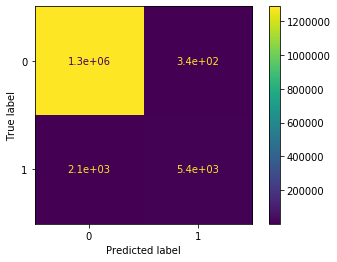

In [158]:
# summarize the fit of the model
expected = y
predicted = model.predict(X) 
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

In [159]:
roc_auc_score(y, predicted)

0.8590490067018857

In [160]:
X = test_4.drop('is_fraud', axis = 1)
X = min_max_scale(X, features_to_scale)
y = test_4.loc[:,'is_fraud']

2020-11-11 20:29:14 Min_max_scale: amt
2020-11-11 20:29:14 Min_max_scale: city_pop
2020-11-11 20:29:14 Min_max_scale: trans_distance
2020-11-11 20:29:15 Min_max_scale: life_time_days
2020-11-11 20:29:15 Min_max_scale: merchant_target_share
2020-11-11 20:29:16 Min_max_scale: birth_year


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.01      0.01      0.01      2145

    accuracy                           0.99    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      0.99      0.99    555719

[[551619   1955]
 [  2123     22]]


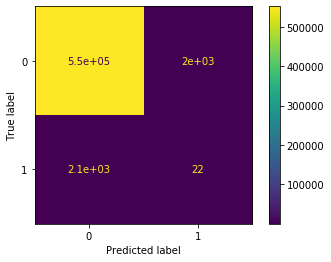

In [161]:
# summarize the fit of the model
expected = y
predicted = model.predict(X)
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_confusion_matrix(model, X, y)

In [162]:
roc_auc_score(y, predicted)

0.5033624068790099

# Early stopping

In [55]:
features_to_scale = ['amt','city_pop', 'trans_distance', 'life_time_days', 
                     'merchant_target_share','birth_year']
train_5 = min_max_scale(train_3, features_to_scale)

2020-11-10 23:06:56 Min_max_scale: amt
2020-11-10 23:06:56 Min_max_scale: city_pop
2020-11-10 23:06:57 Min_max_scale: trans_distance
2020-11-10 23:06:58 Min_max_scale: life_time_days
2020-11-10 23:06:58 Min_max_scale: merchant_target_share
2020-11-10 23:06:59 Min_max_scale: birth_year


In [56]:
target_encoder = TargetEncoder(cols=train_5.select_dtypes(include=[object]).columns)
estimator = XGBClassifier(nthread=-1, n_estimators=1000, learning_rate=0.1)

pipeline = Pipeline([
    ('my_encoder', target_encoder),
    ('my_estimator', estimator)
])

In [57]:
X, X_test, y, y_test = train_test_split(train_5, train_5['is_fraud'],
                                         stratify=train_5['is_fraud'],
                                         test_size=0.3,
                                         random_state=43)

# отделяем от данных для обучения небольшой сэмпл для early_stopping
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                 stratify=y,
                                                 test_size=0.1,
                                                 random_state=43)

# итого
X_train.shape, X_val.shape, X_test.shape

((816904, 14), (90768, 14), (389003, 14))

In [58]:
X_train = X_train.drop(['is_fraud'], axis=1)
X_val = X_val.drop(['is_fraud'], axis=1)
X_test = X_test.drop(['is_fraud'], axis=1)

In [59]:
from sklearn.base import clone

initial_steps = []
for i in pipeline.steps:
    initial_steps.append(clone(i[1]))

transformers_pipeline = make_pipeline(*initial_steps[:-1])
transformers_pipeline.fit(X_train, y_train)

X_val_transformed = transformers_pipeline.transform(X_val)

In [60]:
# передаем в fit параметры для early_stopping как: my_estimator__eval_set
# учится очень быстро -  смысл в том, что берутся случайным образом перемешанные данные
# высокий градиент функции потерь


pipeline.fit(X_train, y_train,
            my_estimator__eval_set=[(X_val_transformed, y_val)], 
            my_estimator__eval_metric='auc', 
            my_estimator__early_stopping_rounds=5, 
            my_estimator__verbose=10)

[0]	validation_0-auc:0.96047
Will train until validation_0-auc hasn't improved in 5 rounds.
[10]	validation_0-auc:0.96618
Stopping. Best iteration:
[12]	validation_0-auc:0.96635



Pipeline(memory=None,
         steps=[('my_encoder',
                 TargetEncoder(cols=Index(['category', 'gender', 'trans_hour', 'trans_week_day'], dtype='object'),
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('my_estimator',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_...
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=-1, nthread=-1, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
           

In [61]:
y_pred = pipeline.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:, 1])

0.9678273182758805

# Test results

In [62]:
X_test_real = test_3.drop('is_fraud', axis = 1)
X_test_real = min_max_scale(X_test_real, features_to_scale)
y_test_real = test_3.loc[:,'is_fraud']

2020-11-10 23:07:41 Min_max_scale: amt
2020-11-10 23:07:42 Min_max_scale: city_pop
2020-11-10 23:07:42 Min_max_scale: trans_distance
2020-11-10 23:07:42 Min_max_scale: life_time_days
2020-11-10 23:07:43 Min_max_scale: merchant_target_share
2020-11-10 23:07:43 Min_max_scale: birth_year


In [63]:
y_pred = pipeline.predict_proba(X_test_real)
roc_auc_score(y_test_real, y_pred[:, 1])

0.9480965907801345

In [23]:
data_tuples = list(zip(y_test_real,list(y_pred[:,1])))
compare = pd.DataFrame(data_tuples, columns=['y_true','y_probas'])
compare['y_probas'] = compare['y_probas'].round(3)

In [ ]:
compare.to_excel('compare_8.xlsx', index = False)

# Feature importance

In [81]:
fi=pd.DataFrame({'importance':pipeline[1].feature_importances_},index=X_train.columns)
fi.sort_values('importance',ascending=False).head(15)
# берем фичу, по ней упорядочиваем весь датасет. Например отсортировали по возрасту. Смотрим как поверхность делит выборку и на какие состояния
# например больши и меньше 30 лет. На этих областях считается empurity из пропорций
# всего доля единичек - 1%. Меньше 30 - 0.5% а больше 30 - 0.5%
# Критерий Джини: - 1 - вероятность 1 класса и 1 - вероятность 0 класса. 
# При каждом делении неопределенность должна уменьшаться. 1 минус сумма квадратов по одному классу и 1 минус сумма квадратов по другому классу. 
# Когда по какой-то фиче делим - получаем информационный прирост.
# featureimportance - информационный прирост, полученный для каждой фичи. какая-то фича может фигурировать в нескольких уровнях дерева. 
# featureimportance - пример с шафматной доской (делим несколько раз вдоль и поперек)



,importance
trans_hour,0.198757
typical_zip,0.193100
amt_norm,0.189923
category,0.154310
earlier_fraudster,0.074473
gender,0.071177
birth_year_norm,0.066733
merchant_target_share_norm,0.031752
city_pop_norm,0.012960
life_time_days_norm,0.006416


In [24]:
test

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_dttm,birth_year,trans_week_day,trans_distance,typical_zip,typical_job,earlier_fraudster
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,12,2020-06-21 12:14:25,1968,Sunday,24.569172,1,1,1
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,12,2020-06-21 12:14:33,1990,Sunday,104.958031,1,1,1
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,12,2020-06-21 12:14:53,1970,Sunday,59.098624,1,1,1
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,12,2020-06-21 12:15:15,1987,Sunday,27.707262,1,1,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,12,2020-06-21 12:15:17,1955,Sunday,104.367859,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,Luray,MO,63453,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,23,2020-12-31 23:59:07,1966,Thursday,77.050328,1,1,0
555715,555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,23,2020-12-31 23:59:09,1999,Thursday,100.105836,1,1,1
555716,555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,23,2020-12-31 23:59:15,1981,Thursday,80.784654,1,1,1
555717,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,Mesa,ID,83643,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,23,2020-12-31 23:59:24,1965,Thursday,52.949857,1,1,1


,category_entertainment,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M
0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
555715,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
555716,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
555717,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [ ]:
# попробовать несколько моделей. 